**ResNet 18 모델 정의 및 인스턴스 초기화**
- 일반적인 ResNet18 모델 아키텍처 사용
- 배치 정규화 사용 여부 설정

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [12]:
#ResNet18을 위해 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, with_BN, stride=1):
    super(BasicBlock, self).__init__()
    self.with_BN = with_BN

    #3x3 필터를 사용 (너비와 높이를 줄일때는 stride 값 조절)
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    if with_BN: #배치 정규화를 사용하는 경우
      self.bn1 = nn.BatchNorm2d(planes)

    #3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이 동일)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    if with_BN: #배치 정규화를 사용하는 경우
      self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential() #단순한 identity mapping인 경우
    if stride != 1: #stride가 1이 아니라면, identity mapping이 아닌경우
      modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
      if with_BN:
        modules.append(nn.BatchNorm2d(planes))
      self.shortcut =  nn.Sequential(*modules)

  def forward(self,x):
    if self.with_BN: #배치 정규화를 사용하는 경우
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
    else:
      out = F.relu(self.conv1(x))
      out = self.conv2(out)
    out += self.shortcut(x) # skip connection
    out = F.relu(out)
    return out

In [22]:
#ResNet 클래스 정의
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, with_BN, num_classes=10):
    super(ResNet, self).__init__()
    self. in_planes = 64
    self.with_BN = with_BN

    #64개의 3x3 필터 사용
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    if with_BN: #배치 정규화를 사용하는 경우
      self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, with_BN, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
    self.linear = nn.Linear(512, num_classes)

  def _make_layer(self, block, planes, with_BN, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks -1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, with_BN, stride))
      self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
    return nn.Sequential(*layers)

  def forward(self, x):
    if self.with_BN: #배치 정규화를 사용하는 경우
      out = F.relu(self.bn1(self.conv1(x)))
    else:
      out = F.relu(self.conv1(x))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


In [23]:
def ResNet18(with_BN):
  return ResNet(BasicBlock, [2,2,2,2], with_BN)

**데이터셋 다운로드 및 불러오기**
- 실험을 위해 CIFAR-10 데이터셋을 사용

In [32]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
])
transform_test = transforms.Compose([
                                     transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**학습(Training) 및 테스트(Test) 함수 정의**

In [33]:
criterion = nn.CrossEntropyLoss() #분류 문제

def train(net, optimzer, epoch, step):
  net.train() #network를 학습모드로 전환
  correct = 0 #정답을 맞힌 이미지 개수
  total = 0 #전체 이미지 개수
  steps = [] #학습 스텝
  losses = [] #각 스텝에서의 손실

  for _, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item() #predicted.eq(data)는 predicted배열과 targets가 일치하는지 확인 / sum()을 붙혀서 일치하는 것들의 개수의 합을 숫자로 출력  
    total += targets.size(0)

    steps.append(step)
    losses.append(loss.item())
    step += 1

  return correct / total, steps, losses

In [34]:
def test(net, optimizer, epoch):
  net.eval() #network를 평가모드로 전환
  correct = 0 #정답을 맞힌 이미지 개수
  total = 0 #전체 이미지 개수
  loss = 0 #손실

  for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    outputs = net(inputs)
    loss += criterion(outputs, targets).item()
    
    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item()
    total += targets.size(0)

  return correct / total, loss

**Without BN : 학습 진행**
- 먼저 BatchNorm을 적용하지 않은 모델의 성능을 평가합니다.
- 기본적으로 Residual Connection은 Loss Landscape Smoothing의 효과가 있다는 점을 감안

In [35]:
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

학습 가능한 총 파라미터 수: 11164362


In [36]:
without_BN_train_accuracy = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracy = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0,epochs):
  print(f'[Epoch: {epoch} / {epochs}]')
  train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
  without_BN_train_accuracy.append(train_accuracy)
  without_BN_steps.extend(steps)
  without_BN_train_losses.extend(train_losses)
  print(f'Train accuracy = {train_accuracy * 100: .2f} / Train loss = {sum(train_losses)}')

  test_accuracy, test_loss = test(net, optimizer, epoch)
  without_BN_test_accuracy.append(test_accuracy)
  without_BN_test_losses.append(test_loss)
  print(f'Test accuracy = {test_accuracy * 100: .2f} / Test loss = {test_loss}')

[Epoch: 0 / 20]
Train accuracy =  18.29 / Train loss = 1678.3745220899582
Test accuracy =  27.42 / Test loss = 389.3721331357956
[Epoch: 1 / 20]
Train accuracy =  31.52 / Train loss = 1443.175411581993
Test accuracy =  40.73 / Test loss = 323.6443200111389
[Epoch: 2 / 20]
Train accuracy =  40.23 / Train loss = 1269.6331584453583
Test accuracy =  42.69 / Test loss = 309.72046875953674
[Epoch: 3 / 20]
Train accuracy =  46.23 / Train loss = 1151.7669407129288
Test accuracy =  49.82 / Test loss = 273.14918076992035
[Epoch: 4 / 20]
Train accuracy =  52.03 / Train loss = 1040.546179652214
Test accuracy =  54.95 / Test loss = 254.0638016462326
[Epoch: 5 / 20]
Train accuracy =  57.38 / Train loss = 931.533974647522
Test accuracy =  61.47 / Test loss = 215.1733562350273
[Epoch: 6 / 20]
Train accuracy =  62.30 / Train loss = 834.9254773259163
Test accuracy =  64.24 / Test loss = 200.70198595523834
[Epoch: 7 / 20]
Train accuracy =  66.23 / Train loss = 751.5767434239388
Test accuracy =  68.13 / T

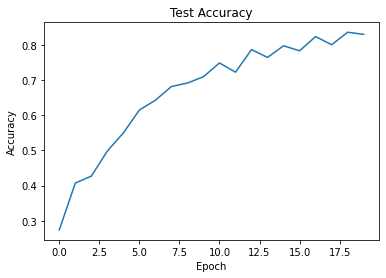

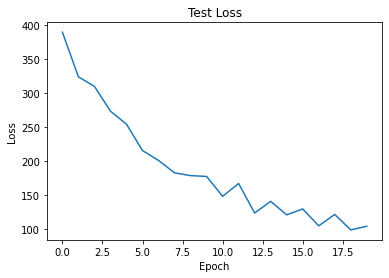

In [38]:
plt.plot([i for i in range(len(without_BN_test_accuracy))], without_BN_test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**With BN : 학습(Training) 진행**
- BatchNorm을 적용해서 성능 평가

In [42]:
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

학습 가능한 총 파라미터 수: 11173962


파라미터가 10000개정도 늘었다.

In [44]:
with_BN_train_accuracy = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracy = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
  print(f'[Epoch: {epoch}/{epochs}')
  train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
  with_BN_train_accuracy.append(train_accuracy)
  with_BN_steps.extend(steps)
  with_BN_train_losses.extend(train_losses)
  print(f'Train accuracy = {train_accuracy * 100: .2f} / Train loss = {sum(train_losses)}')

  test_accuracy, test_loss = test(net, optimizer, epoch)
  with_BN_test_accuracy.append(test_accuracy)
  with_BN_test_losses.append(test_loss)
  print(f'Test accuracy = {test_accuracy * 100: .2f} / Test loss = {test_loss}')

[Epoch: 0/20
Train accuracy =  46.56 / Train loss = 1153.018663406372
Test accuracy =  54.23 / Test loss = 266.7828208208084
[Epoch: 1/20
Train accuracy =  66.17 / Train loss = 746.1071539521217
Test accuracy =  70.94 / Test loss = 168.0137844979763
[Epoch: 2/20
Train accuracy =  74.14 / Train loss = 579.9807824790478
Test accuracy =  71.73 / Test loss = 170.1326460838318
[Epoch: 3/20
Train accuracy =  78.40 / Train loss = 483.4044394791126
Test accuracy =  78.69 / Test loss = 125.56007903814316
[Epoch: 4/20
Train accuracy =  81.34 / Train loss = 426.4405865371227
Test accuracy =  78.99 / Test loss = 125.04409627616405
[Epoch: 5/20
Train accuracy =  83.12 / Train loss = 382.4566866904497
Test accuracy =  78.82 / Test loss = 135.24363927543163
[Epoch: 6/20
Train accuracy =  84.87 / Train loss = 341.7293598651886
Test accuracy =  84.16 / Test loss = 93.69909878075123
[Epoch: 7/20
Train accuracy =  86.20 / Train loss = 311.4805623739958
Test accuracy =  84.35 / Test loss = 92.281662896275

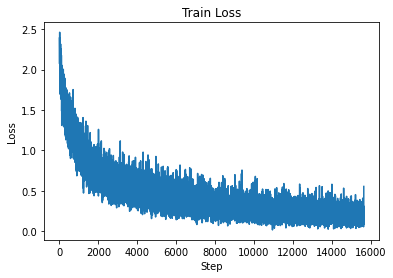

In [47]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel("Step")
plt.ylabel('Loss')
plt.show()

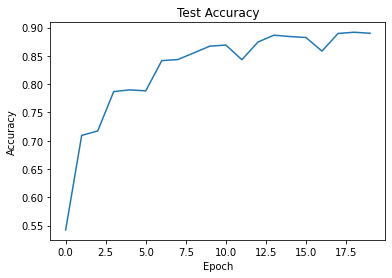

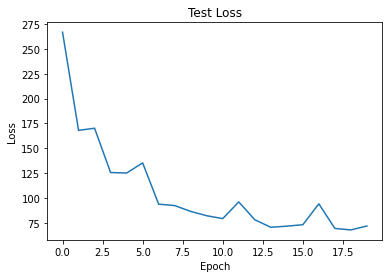

In [48]:
plt.plot([i for i in range(len(with_BN_test_accuracy))], with_BN_test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**w/o BN 과 w/ BN 비교하기**
- 배치 정규화를 이용할 때 손실 값의 변동 폭이 작다.
- 성능이 훨씬 좋아지고, 초반에 빠른 성능 향상을 보인다.

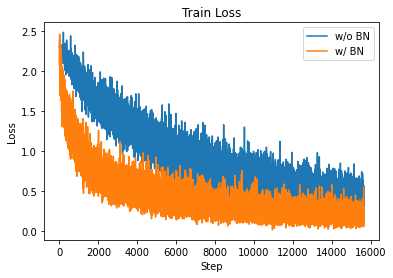

In [49]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

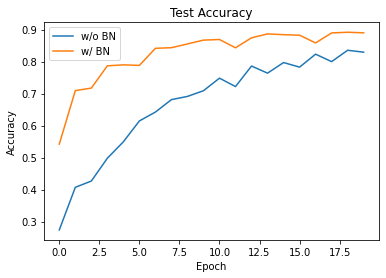

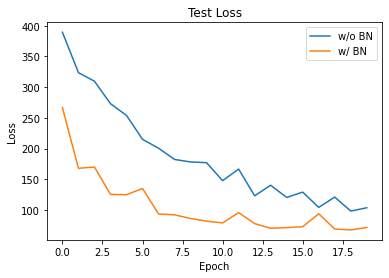

In [50]:
plt.plot([i for i in range(len(without_BN_test_accuracy))], without_BN_test_accuracy)
plt.plot([i for i in range(len(with_BN_test_accuracy))], with_BN_test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()